In [27]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np 
from AutoEncoder_util import convert_type, transform_data, mad_score
from Feature_engineer import remove_unwanted_col_autoencoder,feature_engineer_steps
from Data_preprocessing_method import apply_PCA
from result_display import show_result,export_anomaly
import matplotlib.pyplot as plt
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
import mlflow.tensorflow

In [28]:
transactions_df = pd.read_csv("data/user_demo_data.csv")
terminal_profiles_df = pd.read_csv("data/terminal_profiles_table.csv")
customer_profiles_df = pd.read_csv("data/customer_profiles_table.csv")
join_terminal = pd.merge(transactions_df, terminal_profiles_df, on='terminal_id', how='inner') #join dataset base on key value
join_customer = pd.merge(join_terminal, customer_profiles_df, on='customer_id', how='inner')


In [29]:
test_X,test_y = feature_engineer_steps(join_customer)
test_X = remove_unwanted_col_autoencoder(test_X)

test_X = convert_type(test_X)
test_y = convert_type(test_y)

In [30]:
best_model = load_model('saved_model/autoencoder_best_weights.keras')


In [31]:
#  Transform test data
test_X_transformed = transform_data(test_X)

reconstructions = best_model.predict(test_X_transformed)
mse = np.mean(np.power(test_X_transformed - reconstructions, 2), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


In [38]:
THRESHOLD = 1.4
z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD


Detected 1,723 outliers in a total of 10,000 transactions [17.23%].


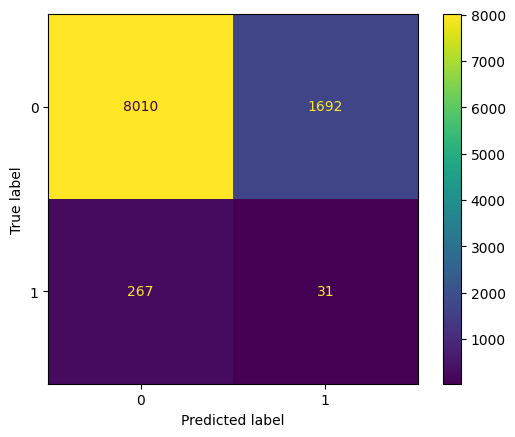

In [39]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")
precision, recall, f1_socre = show_result(test_y,outliers,"result/confusion_matrix_autoencoder.png")
metrics= {"precision": precision, "recall": recall, "f1_socre": f1_socre,"train_threshold":THRESHOLD}

9702
298


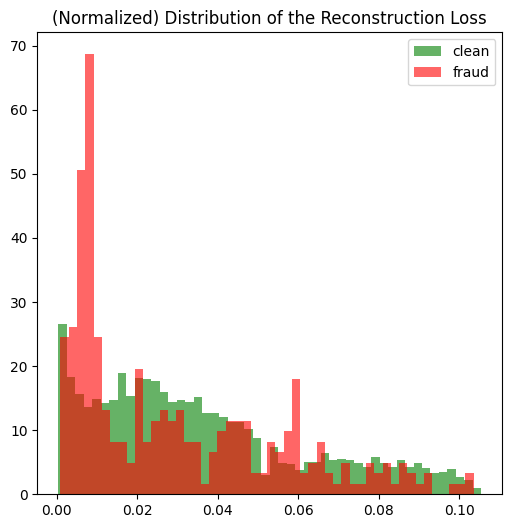

In [40]:
test_y = test_y.reset_index(drop = True)
clean = mse[test_y['fraud']==0]
fraud = mse[test_y['fraud']==1]
print(len(clean))
print(len(fraud))
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

**Load model with PCA**

In [41]:
best_model_PCA = load_model('saved_model/autoencoder_best_weights_PCA.keras')


In [42]:
test_X_transformed_PCA = apply_PCA(test_X_transformed,7)
reconstructions = best_model_PCA.predict(test_X_transformed_PCA)
mse = np.mean(np.power(test_X_transformed_PCA - reconstructions, 2), axis=1)
THRESHOLD = 1.3
z_scores = mad_score(mse)
outliers_PCA = z_scores > THRESHOLD


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


9702
298


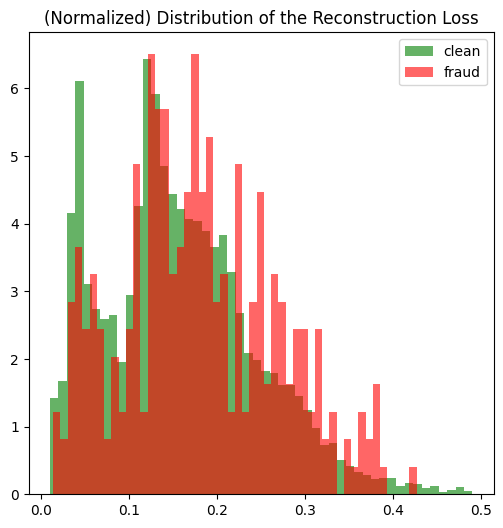

In [43]:
test_y = test_y.reset_index(drop = True)
clean = mse[test_y['fraud']==0]
fraud = mse[test_y['fraud']==1]
print(len(clean))
print(len(fraud))
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

Detected 1,791 outliers in a total of 10,000 transactions [17.91%].


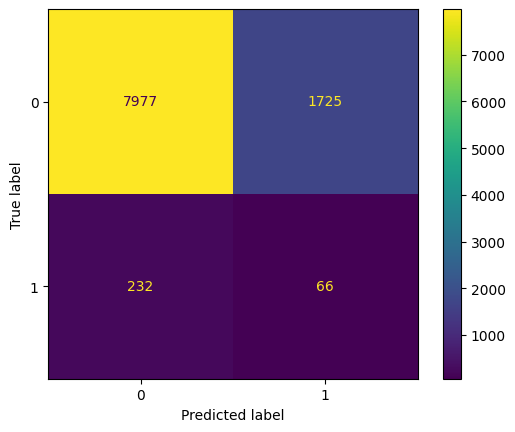

In [44]:
print(f"Detected {np.sum(outliers_PCA):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers_PCA)/np.size(z_scores):.2%}].")
precision_PCA, recall_PCA, f1_socre_PCA = show_result(test_y,outliers_PCA,"result/confusion_matrix_autoencoder_PCA.png")
metrics_PCA = {"precision": precision_PCA, "recall": recall_PCA, "f1_socre": f1_socre_PCA,"train_threshold":THRESHOLD}

***Mlflow related code***

In [45]:
#listening to port
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("AutoEncoder_model")

<Experiment: artifact_location='/mnt/c/Users/Leonwu/Desktop/Master_course/COMP9900/capstone-project-9900f16agptea/mlflow_tracking_server/1', creation_time=1712757880874, experiment_id='1', last_update_time=1712757880874, lifecycle_stage='active', name='AutoEncoder_model', tags={}>

In [48]:
# log model into mlflow

# Initiate the MLflow run context
with mlflow.start_run(run_name="AutoEncoder_PCA") as run:
    # Log the parameters used for the model fit
    mlflow.log_param("batch_size", "256")
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "mse")
    mlflow.log_param("EPOCHS", 100)
    mlflow.log_param("activation_function", "relu")
    mlflow.log_param("num_layers", 9)
    mlflow.log_param("threshold", THRESHOLD)
    mlflow.log_param("PCA_sample", 7)
    mlflow.log_artifact(local_path = "Feature_engineer.py")
    mlflow.log_metrics(metrics_PCA)
    mlflow.log_artifact("result/confusion_matrix_autoencoder_PCA.png")
    # Log an instance of the trained model for later use
    model_info = mlflow.tensorflow.log_model(best_model_PCA, artifact_path="mlruns", registered_model_name="AutoEncoder_PCA")
    

# Initiate the MLflow run context
with mlflow.start_run(run_name="AutoEncoder") as run:
    # Log the parameters used for the model fit
    mlflow.log_param("batch_size", "256")
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "mse")
    mlflow.log_param("EPOCHS", 100)
    mlflow.log_param("activation_function", "relu")
    mlflow.log_param("num_layers", 9)
    mlflow.log_artifact(local_path = "Feature_engineer.py")
    mlflow.log_metrics(metrics)
    mlflow.log_artifact("result/confusion_matrix_autoencoder.png")
    
    #mlflow.log_param("threshold", train_threshold_PCA)
    #mlflow.log_param("PCA_sample", 12)
    # Log an instance of the trained model for later use
    model_info = mlflow.tensorflow.log_model(best_model, artifact_path="mlruns", registered_model_name="AutoEncoder")
    


2024/04/17 04:32:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
Registered model 'AutoEncoder_PCA' already exists. Creating a new version of this model...
2024/04/17 04:32:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: AutoEncoder_PCA, version 39
Created version '39' of model 'AutoEncoder_PCA'.
2024/04/17 04:32:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
Registered model 'AutoEncoder' already exists. Creating a new version of this model...
2024/04/17 04:32:34 INFO mlflow.store.model_registry.abstract_store: W